<a href="https://colab.research.google.com/github/AlexanderWeismannn/ML-Paper-Replication/blob/main/pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Deployment Of A Pytorch Model Using Google Colab

#Get Data (Pizza/Steak/Sushi 20%)
try:
  import torch
  import torchvision
  print("Pytorch and Torchvision already imported")
except:
  print('[INFO] Pytorch and Torchvision not imported, installing...')
  !pip install torch torchvision
  import torch
  import torchvision
  print("Pytorch and Torchvision imported")


Pytorch and Torchvision already imported


In [3]:
#clone git repo
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 14.56 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [4]:
#setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
#download data for the dataset creation
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [6]:
train_data = data_20_percent_path/"train"
test_data = data_20_percent_path/"test"

In [7]:
#get effnets weight
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

#get effnets transforms
effnetb2_transforms = effnetb2_weights.transforms()

#Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

#Freeze the base layers of the model so we can transform the output layer
for param in effnetb2.parameters():
  param.requires_grad = False

effnetb2.classifier

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 181MB/s]


Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
#update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3,inplace=True),
    nn.Linear(in_features= 1408, out_features= 3))

In [9]:
from torchinfo import summary
summary(effnetb2,
        input_size= (1,3,224,224),
        col_names= ["input_size","output_size","num_params","trainable"],
        col_width= 20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [10]:
def create_effnetb2_model(num_classes: int=3,
                          seed:int=42):
  #1,2,3 create weights transforms and model
  #get effnets weight
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

  #get effnets transforms
  transforms = weights.transforms()

  #Setup pretrained model
  model = torchvision.models.efficientnet_b2(weights=weights)

  #4 Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  #5. Change classifier head to our desired num_classes
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3,inplace=True),
    nn.Linear(in_features= 1408, out_features= num_classes))

  return model,transforms




In [11]:
effnetb2,effnetb2_transforms = create_effnetb2_model(num_classes=3,seed=42)
from torchinfo import summary
summary(effnetb2,
        input_size= (1,3,224,224),
        col_names= ["input_size","output_size","num_params","trainable"],
        col_width= 20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [12]:
# Turn data into dataloaders
from going_modular.going_modular import data_setup
train_dataloader,test_dataloader,class_names = data_setup.create_dataloaders(train_dir=train_data,
                                                                             test_dir=test_data,
                                                                             transform=effnetb2_transforms,
                                                                             batch_size=32,)
len(train_dataloader),len(test_dataloader),class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [13]:
#Train the EffnetB2 Feature Extractor
from going_modular.going_modular import engine

#setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

#setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

#Set seeds for reproduction
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


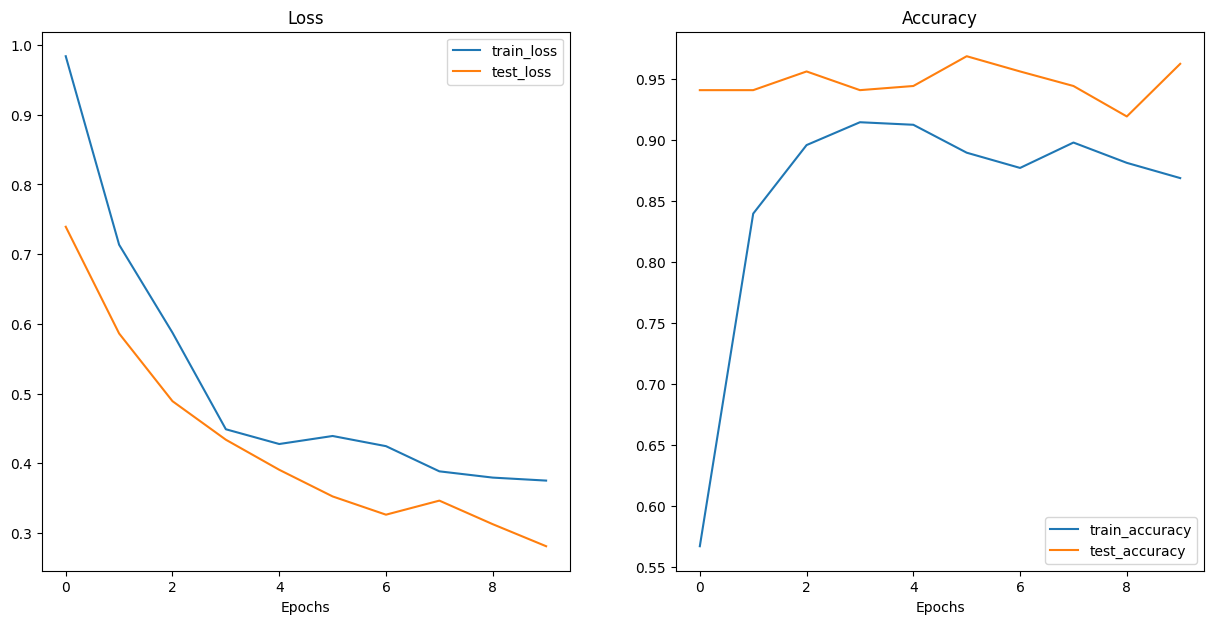

In [14]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_results)

In [15]:
from going_modular.going_modular import utils
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="effnetb2_20_percent.pth")

[INFO] Saving model to: models/effnetb2_20_percent.pth


In [16]:
from pathlib import Path
#get the models size
pretrained_effnetb2_model_size = Path("models/effnetb2_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained EffnetB2 Feature Extractor Model Size: {pretrained_effnetb2_model_size} MB")

Pretrained EffnetB2 Feature Extractor Model Size: 29 MB


In [17]:
# colelct effnet feature extractor stats
effnet_b2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnet_b2_total_params

7705221

In [18]:
effnet_b2_stats = {"test_loss":effnetb2_results["test_loss"][-1],
                   "test_acc":effnetb2_results["test_acc"][-1],
                   "num_params":effnet_b2_total_params,
                   "model_size":pretrained_effnetb2_model_size}
effnet_b2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'num_params': 7705221,
 'model_size': 29}

In [19]:
#Now creating the same feature extractor using a Vit model
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [20]:

def create_vit_model(num_classes:int=3,seed:int=42):
  #import values
  weights= torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms= weights.transforms()
  model=torchvision.models.vit_b_16(weights=weights)

  #freeze all layers
  for param in model.parameters():
    param.requries_grad= False

  #change the classifier head to the num_classes size and unfreeze
  torch.manual_seed(seed)
  model.heads= nn.Sequential(
      nn.Linear(in_features= 768,out_features= num_classes)
  )
  return model,transforms

In [21]:
vit, vit_transforms = create_vit_model(num_classes=3,seed=42)
#summarize the model spec
from torchinfo import summary
summary(vit,
        input_size=[1,3,224,224],
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 168MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

In [22]:
#create dataloaders for the vit model
from going_modular.going_modular import data_setup
train_dataloader,test_dataloader,class_names = data_setup.create_dataloaders(train_dir=train_data,
                                                                             test_dir=test_data,
                                                                             transform=vit_transforms,
                                                                             batch_size=32,)
len(train_dataloader),len(test_dataloader),class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [23]:
#Train the EffnetB2 Feature Extractor
from going_modular.going_modular import engine

#setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

#setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

#Set seeds for reproduction
set_seeds()
vit_results = engine.train(model=vit,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6258 | train_acc: 0.3083 | test_loss: 1.1380 | test_acc: 0.3625
Epoch: 2 | train_loss: 1.1046 | train_acc: 0.3875 | test_loss: 1.0463 | test_acc: 0.3443
Epoch: 3 | train_loss: 1.0470 | train_acc: 0.4792 | test_loss: 1.0855 | test_acc: 0.3659
Epoch: 4 | train_loss: 1.0013 | train_acc: 0.5146 | test_loss: 0.9693 | test_acc: 0.5369
Epoch: 5 | train_loss: 0.9730 | train_acc: 0.5042 | test_loss: 0.9863 | test_acc: 0.5233
Epoch: 6 | train_loss: 0.9716 | train_acc: 0.5083 | test_loss: 1.0732 | test_acc: 0.3818
Epoch: 7 | train_loss: 0.9753 | train_acc: 0.5188 | test_loss: 1.0449 | test_acc: 0.4653
Epoch: 8 | train_loss: 0.9433 | train_acc: 0.5771 | test_loss: 0.9448 | test_acc: 0.5062
Epoch: 9 | train_loss: 0.9305 | train_acc: 0.5563 | test_loss: 1.0018 | test_acc: 0.4903
Epoch: 10 | train_loss: 0.9990 | train_acc: 0.5125 | test_loss: 0.9174 | test_acc: 0.6244


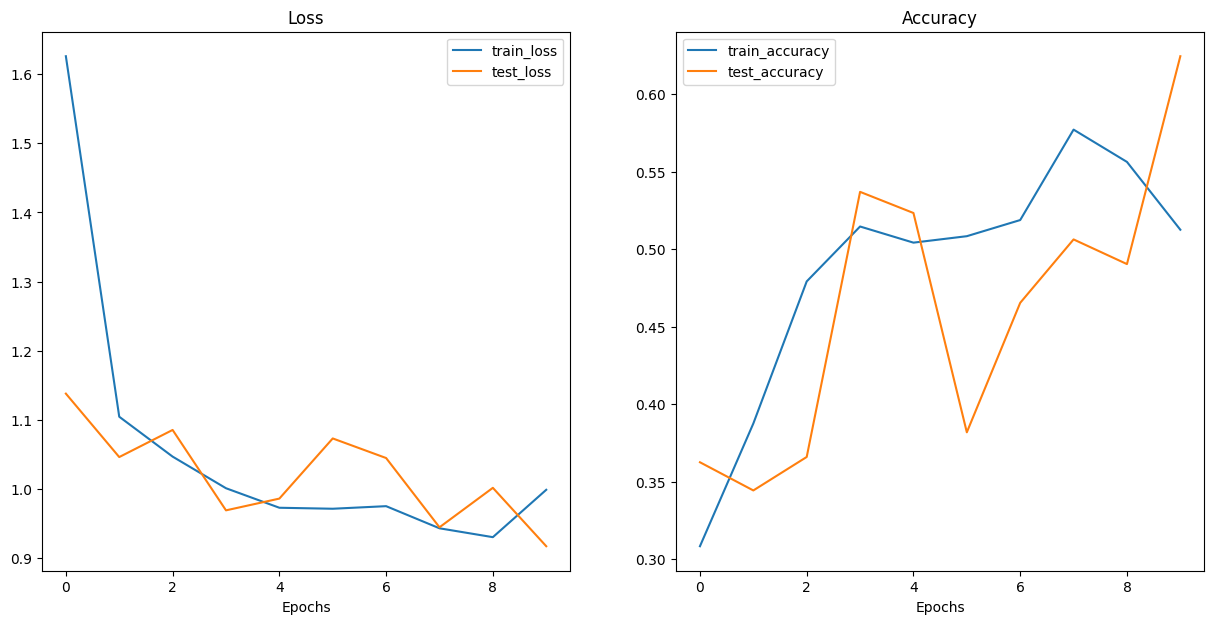

In [24]:
plot_loss_curves(vit_results)

In [25]:
from going_modular.going_modular import utils
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="vit_20_percent.pth")

[INFO] Saving model to: models/vit_20_percent.pth


In [26]:
from pathlib import Path
#get the models size
pretrained_vit_model_size = Path("models/vit_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained Vit Feature Extractor Model Size: {pretrained_vit_model_size} MB")

Pretrained Vit Feature Extractor Model Size: 327 MB


In [27]:
# colelct effnet feature extractor stats
vit_params = sum(torch.numel(param) for param in vit.parameters())
vit_params

85800963

In [28]:
vit_stats = {"test_loss":vit_results["test_loss"][-1],
                   "test_acc":vit_results["test_acc"][-1],
                   "num_params":vit_params,
                   "model_size":pretrained_vit_model_size}
vit_stats

{'test_loss': 0.9174204230308532,
 'test_acc': 0.6244318181818181,
 'num_params': 85800963,
 'model_size': 327}

In [29]:
#Worse accuracy and size makes the effnet the obvious choice
#Just in case ill test the prediction time
import pandas as pd
df = pd.DataFrame([effnet_b2_stats,vit_stats])
df['model'] = ["EffnetB2","ViT"]
df['tets_acc'] = round(df['test_acc'] * 100,2)
df

,test_loss,test_acc,num_params,model_size,model,tets_acc
0,0.281087,0.962500,7705221,29,EffnetB2,96.25
1,0.917420,0.624432,85800963,327,ViT,62.44


In [29]:
#compare model speeds